In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import sys
#import efficientnet.keras as efn 

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [ ]:
from numpy import load
x1 = load('/content/gdrive/My Drive/tesisdatabase/xaptos.npy')

In [ ]:
y1 = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
print(x1.shape)
print(y1.shape)

(3662, 224, 224, 3)
(3662, 5)


In [ ]:
train_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/test.csv')

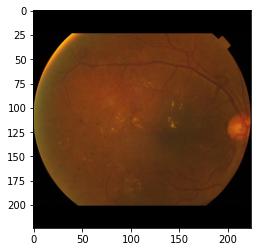

In [ ]:
plt.imshow(x1[0])

In [ ]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

(177, 177, 3)


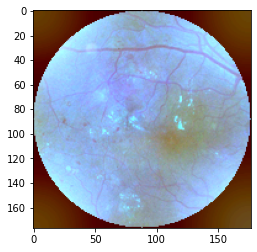

In [ ]:
test= circle_crop(x1[0])
plt.imshow(test)
print(test.shape)

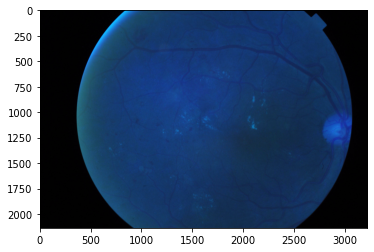

In [ ]:
plt.imshow(cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png'))

In [ ]:
from PIL import Image

def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:

        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:

        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 0)) #fondo negro o blanco
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

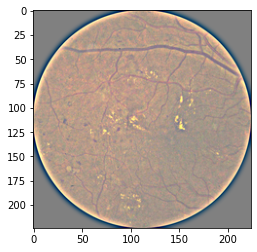

In [ ]:
N = train_df.shape[0]
x_train = np.zeros((N, 224, 224, 3), dtype='uint8')

img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
img=circle_crop(img)
pilim =Image.fromarray(img)
img= resize(pilim,224,224)
imga=np.array(img) 
plt.imshow(imga)

In [ ]:
N = train_df.shape[0]
x_train = np.zeros((N, 224, 224, 3), dtype='uint8')

for i, image_id in enumerate(tqdm(train_df['id_code'])):
  img = cv2.imread(f'/content/gdrive/My Drive/APTOS1/train_images/{image_id}.png')
  img=circle_crop(img)
  pilim =Image.fromarray(img)
  img= resize(pilim,224,224)
  imga=np.array(img) 
  x_train[i,:,:,:] = imga

100%|██████████| 3662/3662 [1:17:55<00:00,  1.28s/it]


In [ ]:
x_train.shape

(3662, 224, 224, 3)

In [ ]:
y = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y, 
    test_size=0.15, 
    random_state=2020
)

In [ ]:
FACTOR = 4
BATCH_SIZE = 8 * FACTOR
IMG_SIZE = 512
EPOCHS = 20
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4 * FACTOR
WARMUP_LEARNING_RATE = 1e-3 * FACTOR
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

LR_WARMUP_EPOCHS_1st = 2
LR_WARMUP_EPOCHS_2nd = 5
STEP_SIZE = len(x_train) // BATCH_SIZE
TOTAL_STEPS_1st = WARMUP_EPOCHS * STEP_SIZE
TOTAL_STEPS_2nd = EPOCHS * STEP_SIZE
WARMUP_STEPS_1st = LR_WARMUP_EPOCHS_1st * STEP_SIZE
WARMUP_STEPS_2nd = LR_WARMUP_EPOCHS_2nd * STEP_SIZE

In [ ]:
def multiple_outputs(generator,x, y, batch_size):
    gen = generator.flow(x, y, batch_size=batch_size, seed=2020)
    
    mlb = MultiLabelBinarizer(classes = range(N_CLASSES))
    
    while True:
        gnext = gen.next()
        yield gnext[0], [np.argmax(gnext[1],axis = -1),gnext[1],mlb.fit_transform([list(range(x+1)) for x in np.argmax(gnext[1],axis = -1)])]

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.)

train_generator = multiple_outputs(generator = train_datagen,x = x_train,
                                   y= y_train,
                                   batch_size=BATCH_SIZE)
     
valid_generator = multiple_outputs(generator = train_datagen,x = x_val,
                                   y= y_val,
                                   batch_size=BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
import pandas as pd
import numpy as np
import itertools
import os
import sys
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,BatchNormalization,GlobalMaxPooling2D,concatenate,Flatten
from keras.callbacks.callbacks import EarlyStopping,ReduceLROnPlateau,Callback
from keras.initializers import random_normal
from keras.models import load_model
from keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
from keras import backend as K

import tensorflow as tf

4  CPU cores


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
input_tensor = Input(shape=(224, 224, CANAL))
base_model = applications.ResNet50(weights=None, include_top=False,input_tensor=input_tensor)
base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

x1 = GlobalAveragePooling2D()(base_model.output)
x1 = BatchNormalization()(x1)

x2 = GlobalMaxPooling2D()(base_model.output)
x2 = BatchNormalization()(x2)

x = concatenate([x1,x2])

# Regression Head
xr = Dense(2048, activation='relu')(x)
xr = Dropout(0.5)(xr)
xr = Dense(1,activation = 'linear',name = 'regression_output')(xr)

# Classification Head
xc = Dense(2048, activation='relu')(x)
xc = Dropout(0.5)(xc)
xc = Dense(N_CLASSES,activation = 'softmax',name = 'classification_output')(xc)

# Ordinal Regression Head
xo = Dense(2048, activation='relu')(x)
xo = Dropout(0.5)(xo)
xo = Dense(N_CLASSES,activation = 'softmax',name = 'ordinal_regression_output')(xo)

model = Model(inputs = [input_tensor], outputs = [xr,xc,xo])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:

STEP_SIZE_TRAIN = len(x_train)//BATCH_SIZE
STEP_SIZE_VALID = len(x_val)//BATCH_SIZE
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

97 17


In [ ]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """
    Cosine decay schedule with warm up period.
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    :param global_step {int}: global step.
    :param learning_rate_base {float}: base learning rate.
    :param total_steps {int}: total number of training steps.
    :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
    :param warmup_steps {int}: number of warmup steps. (default: {0}).
    :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
    :param global_step {int}: global step.
    :Returns : a float representing learning rate.
    :Raises ValueError: if warmup_learning_rate is larger than learning_rate_base, or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)

class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler"""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """
        Constructor for cosine decay with warmup learning rate scheduler.
        :param learning_rate_base {float}: base learning rate.
        :param total_steps {int}: total number of training steps.
        :param global_step_init {int}: initial global step, e.g. from previous checkpoint.
        :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
        :param warmup_steps {int}: number of warmup steps. (default: {0}).
        :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
        :param verbose {int}: quiet, 1: update messages. (default: {0}).
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

In [ ]:
cosine_lr = WarmUpCosineDecayScheduler(learning_rate_base = LEARNING_RATE,
                                       total_steps=TOTAL_STEPS_1st,
                                       warmup_learning_rate=0.0,
                                       warmup_steps=TOTAL_STEPS_1st,
                                       hold_base_rate_steps=(2 * STEP_SIZE))

callback_list = [cosine_lr]

In [ ]:
model.compile(optimizer = optimizers.SGD(lr=LEARNING_RATE),
              loss={'regression_output': 'mean_absolute_error', 
                    'classification_output': 'categorical_crossentropy',
                    'ordinal_regression_output' : 'binary_crossentropy'
                    },
              metrics = ['accuracy'])

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=20,
                              callbacks = callback_list,
                              verbose=1).history

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


97/97 [==============================] - 54s 559ms/step - loss: 5.2854 - regression_output_loss: 2.0196 - classification_output_loss: 2.1821 - ordinal_regression_output_loss: 1.0836 - regression_output_accuracy: 0.1566 - classification_output_accuracy: 0.2619 - ordinal_regression_output_accuracy: 0.5767 - val_loss: 5.2577 - val_regression_output_loss: 2.0739 - val_classification_output_loss: 1.7684 - val_ordinal_regression_output_loss: 1.1272 - val_regression_output_accuracy: 0.0368 - val_classification_output_accuracy: 0.0809 - val_ordinal_regression_output_accuracy: 0.4934
Epoch 2/20
97/97 [==============================] - 37s 377ms/step - loss: 4.0897 - regression_output_loss: 1.4225 - classification_output_loss: 1.6749 - ordinal_regression_output_loss: 0.9923 - regression_output_accuracy: 0.2338 - classification_output_accuracy: 0.4136 - ordinal_regression_output_accuracy: 0.6066 - val_loss: 3.7487 - val_regression_output_loss: 1.4672 - val_classification_output_loss: 1.3443 - val

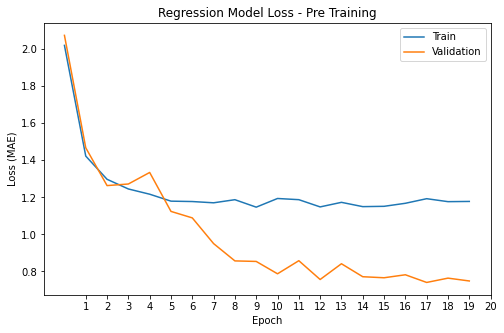

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['regression_output_loss'])
plt.plot(history['val_regression_output_loss'])
plt.title('Regression Model Loss - Pre Training')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

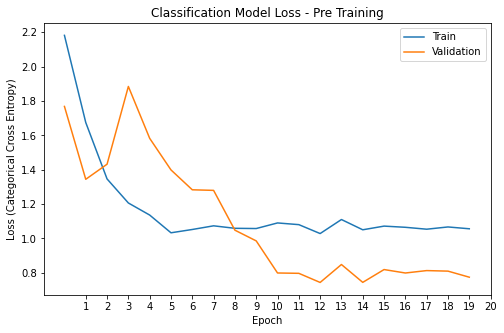

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['classification_output_loss'])
plt.plot(history['val_classification_output_loss'])
plt.title('Classification Model Loss - Pre Training')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

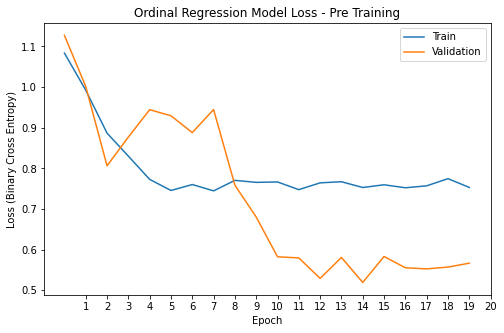

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['ordinal_regression_output_loss'])
plt.plot(history['val_ordinal_regression_output_loss'])
plt.title('Ordinal Regression Model Loss - Pre Training')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
for layer in model.layers:
    layer.trainable = False

for i in range(-14,0):
  model.layers[i].trainable = True

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [ ]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)
    return categorical_focal_loss_fixed

In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),
              loss={'regression_output': mean_squared_error, 
                    'classification_output': categorical_focal_loss(alpha=.25, gamma=2) ,
                    'ordinal_regression_output' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=5,
                              callbacks = callback_list,
                              verbose=1).history

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


97/97 [==============================] - 35s 362ms/step - loss: 2.4479 - regression_output_loss: 2.2587 - classification_output_loss: 0.0410 - ordinal_regression_output_loss: 0.1481 - regression_output_accuracy: 0.2734 - classification_output_accuracy: 0.6370 - ordinal_regression_output_accuracy: 0.6666 - val_loss: 0.9115 - val_regression_output_loss: 0.9382 - val_classification_output_loss: 0.0313 - val_ordinal_regression_output_loss: 0.0966 - val_regression_output_accuracy: 0.4324 - val_classification_output_accuracy: 0.6988 - val_ordinal_regression_output_accuracy: 0.7896
Epoch 2/5
97/97 [==============================] - 30s 314ms/step - loss: 2.3957 - regression_output_loss: 2.2079 - classification_output_loss: 0.0403 - ordinal_regression_output_loss: 0.1474 - regression_output_accuracy: 0.2536 - classification_output_accuracy: 0.6325 - ordinal_regression_output_accuracy: 0.6688 - val_loss: 1.2438 - val_regression_output_loss: 0.8790 - val_classification_output_loss: 0.0297 - val_

In [ ]:
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
model.compile(optimizer = optimizers.Adam(lr=LEARNING_RATE),
              loss={'regression_output': mean_squared_error, 
                    'classification_output': categorical_focal_loss(alpha=.25, gamma=2) ,
                    'ordinal_regression_output' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=45,
                              callbacks = callback_list,
                              verbose=1).history

model.save("model_main_training.h5")

Epoch 1/45


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


97/97 [==============================] - 53s 549ms/step - loss: 2.3629 - regression_output_loss: 2.1753 - classification_output_loss: 0.0384 - ordinal_regression_output_loss: 0.1491 - regression_output_accuracy: 0.2747 - classification_output_accuracy: 0.6464 - ordinal_regression_output_accuracy: 0.6692 - val_loss: 1.3380 - val_regression_output_loss: 0.9339 - val_classification_output_loss: 0.0288 - val_ordinal_regression_output_loss: 0.0955 - val_regression_output_accuracy: 0.3996 - val_classification_output_accuracy: 0.7181 - val_ordinal_regression_output_accuracy: 0.8050
Epoch 2/45
97/97 [==============================] - 37s 380ms/step - loss: 2.3518 - regression_output_loss: 2.1633 - classification_output_loss: 0.0400 - ordinal_regression_output_loss: 0.1487 - regression_output_accuracy: 0.2831 - classification_output_accuracy: 0.6471 - ordinal_regression_output_accuracy: 0.6786 - val_loss: 0.7874 - val_regression_output_loss: 0.9186 - val_classification_output_loss: 0.0271 - val

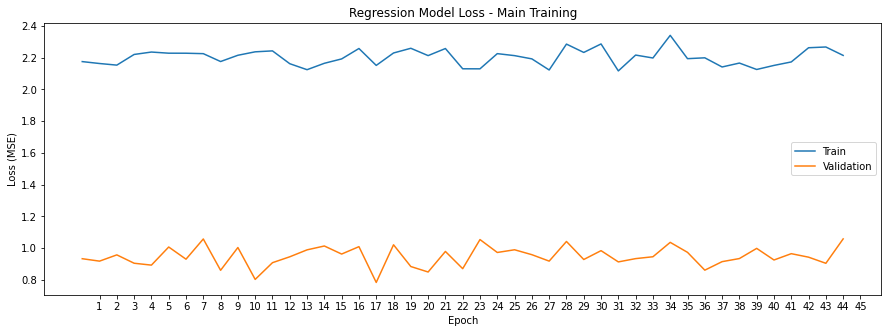

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['regression_output_loss'])
plt.plot(history['val_regression_output_loss'])
plt.title('Regression Model Loss - Main Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,46))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

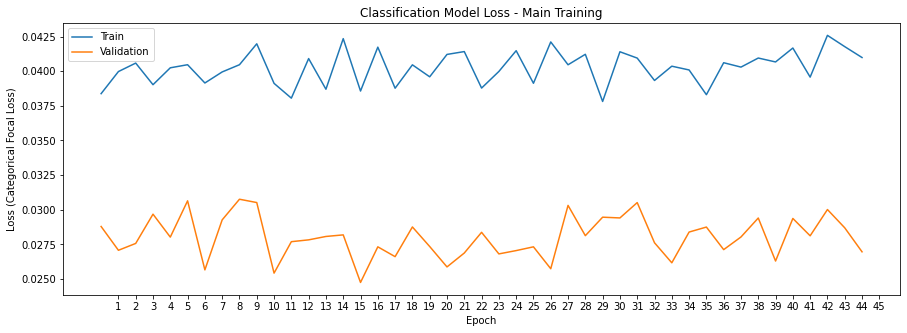

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['classification_output_loss'])
plt.plot(history['val_classification_output_loss'])
plt.title('Classification Model Loss - Main Training')
plt.ylabel('Loss (Categorical Focal Loss)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,46))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

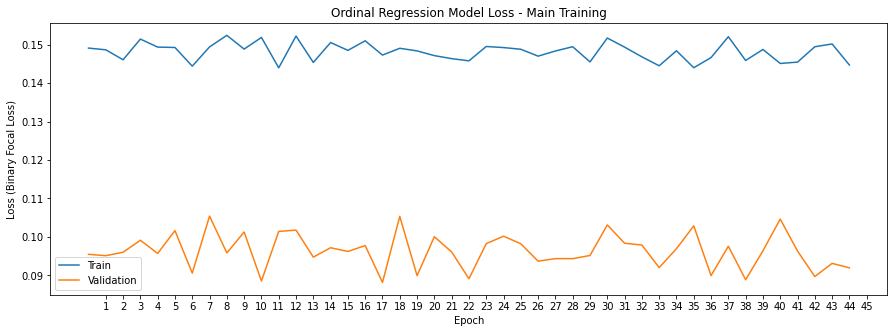

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['ordinal_regression_output_loss'])
plt.plot(history['val_ordinal_regression_output_loss'])
plt.title('Ordinal Regression Model Loss - Main Training')
plt.ylabel('Loss (Binary Focal Loss)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,46))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
complete_generator = complete_datagen.flow(x_train, y_train, batch_size=1, shuffle=False)
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
print(complete_generator.n)


test_generator = complete_generator = complete_datagen.flow(x_val, y_val, batch_size=1, shuffle=False)

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print(test_generator.n)

3112
550


In [ ]:
model = load_model("model_main_training.h5",custom_objects={'categorical_focal_loss_fixed':categorical_focal_loss(alpha=.25, gamma=2),
                                                            'binary_focal_loss_fixed' : binary_focal_loss(alpha=.25, gamma=2)})
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3112/3112 [==============================] - 49s 16ms/step


In [ ]:
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)

 12/550 [..............................] - ETA: 9s

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


550/550 [==============================] - 8s 15ms/step


In [ ]:
print(train_preds[0].shape,train_preds[1].shape,train_preds[2].shape)

train_output_regression = np.array(train_preds[0]).reshape(-1,1)
train_output_classification = np.array(np.argmax(train_preds[1],axis = -1)).reshape(-1,1)
train_output_ordinal_regression = np.array(np.sum(train_preds[2],axis = -1)).reshape(-1,1)

print(train_output_regression.shape,train_output_classification.shape,train_output_ordinal_regression.shape)
X_train = np.hstack((train_output_regression,train_output_classification,train_output_ordinal_regression))
print(X_train.shape)

(3112, 1) (3112, 5) (3112, 5)
(3112, 1) (3112, 1) (3112, 1)
(3112, 3)


In [ ]:
print(test_preds[0].shape,test_preds[1].shape,test_preds[2].shape)

test_output_regression = np.array(test_preds[0]).reshape(-1,1)
test_output_classification = np.array(np.argmax(test_preds[1],axis = -1)).reshape(-1,1)
test_output_ordinal_regression = np.array(np.sum(test_preds[2],axis = -1)).reshape(-1,1)

print(test_output_regression.shape,test_output_classification.shape,test_output_ordinal_regression.shape)
X_test = np.hstack((test_output_regression,test_output_classification,test_output_ordinal_regression))
print(X_test.shape)

(550, 1) (550, 5) (550, 5)
(550, 1) (550, 1) (550, 1)
(550, 3)


In [ ]:
model_post = Sequential()
model_post.add(Dense(1, activation='linear', input_shape=(3,)))
model_post.compile(optimizer=optimizers.SGD(lr=LEARNING_RATE), loss='mean_squared_error', metrics=['mean_squared_error'])
model_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
np.array(train_df.diagnosis.values)

array([2, 4, 1, ..., 2, 0, 2])

In [ ]:
y_val.shape

(550, 5)

In [ ]:
y_train1 = [np.where(r==1)[0][0] for r in y_train]
y_val1 = [np.where(r==1)[0][0] for r in y_val]

In [ ]:
y_train1=np.array(y_train1)
y_val1= np.array(y_val1)

In [ ]:
history = model_post.fit(X_train,y_train1,
                         batch_size=BATCH_SIZE,
                         epochs=50,
                         verbose=1,
                         validation_data = (X_test,y_val1))

model_post.save("model_post_training.h5")

Train on 3112 samples, validate on 550 samples
Epoch 1/50
3112/3112 [==============================] - 0s 72us/step - loss: 4.6423 - mean_squared_error: 4.6423 - val_loss: 3.9821 - val_mean_squared_error: 3.9821
Epoch 2/50
3112/3112 [==============================] - 0s 59us/step - loss: 3.2125 - mean_squared_error: 3.2125 - val_loss: 2.7144 - val_mean_squared_error: 2.7144
Epoch 3/50
3112/3112 [==============================] - 0s 56us/step - loss: 2.5678 - mean_squared_error: 2.5678 - val_loss: 2.0821 - val_mean_squared_error: 2.0821
Epoch 4/50
3112/3112 [==============================] - 0s 53us/step - loss: 2.2667 - mean_squared_error: 2.2667 - val_loss: 1.7589 - val_mean_squared_error: 1.7589
Epoch 5/50
3112/3112 [==============================] - 0s 53us/step - loss: 2.1181 - mean_squared_error: 2.1181 - val_loss: 1.5836 - val_mean_squared_error: 1.5836
Epoch 6/50
3112/3112 [==============================] - 0s 55us/step - loss: 2.0362 - mean_squared_error: 2.0362 - val_loss: 1.4

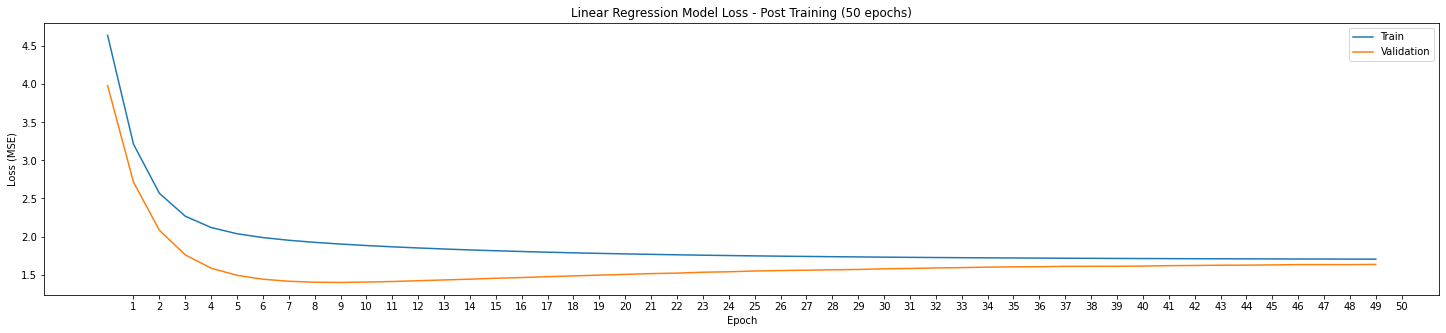

In [ ]:

plt.figure(figsize=(25,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Linear Regression Model Loss - Post Training (50 epochs)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,51))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

In [ ]:
train_labels = model_post.predict(X_train,batch_size=BATCH_SIZE,verbose = 1)
train_labels = np.apply_along_axis(classify, 1, train_labels)

3112/3112 [==============================] - 0s 20us/step


In [ ]:
test_labels = model_post.predict(X_test,batch_size=BATCH_SIZE,verbose = 1)
test_labels = np.apply_along_axis(classify, 1, test_labels)

550/550 [==============================] - 0s 29us/step


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

In [ ]:
list(train_df['diagnosis'].astype(int))

In [ ]:
list(y_val1)

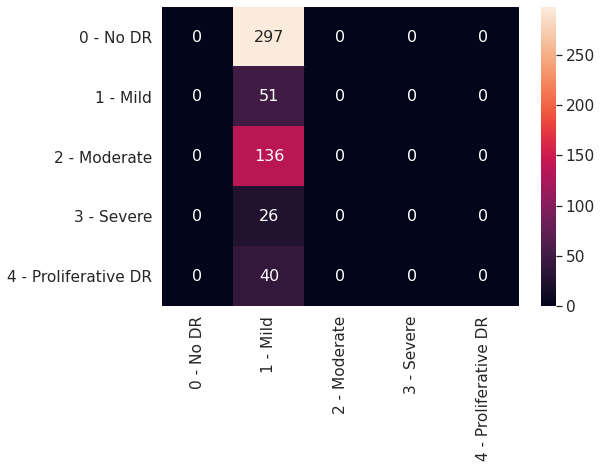

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(y_val1),test_labels,labels)

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_labels, y_train1, weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(y_train1,train_labels))

Train Cohen Kappa score: 0.000
Train Accuracy score : 0.103


In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, y_val1, weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(y_val1,test_labels))

Test Cohen Kappa score: 0.000
Test Accuracy score : 0.093
